# DIC Plastic Strain and Work Hardening

#### Overview of what this notebook does:

From previous notebooks:
- Uses functions from previous work to load in the data from npy files
- Some of these functions were then amended to work for data that had already been loaded in (rather than having to load the data each time)
<br>
<br>Then for this notebook only:
- Stress and strain were converted to true stress and strain, and the Young's modulus was calculated
- Plastic strain was calculated and data cropped to the appropriate length
- Work hardening rate was calculated (using the noise reduction method described in a previoud notebook)
- Work hardening rate was plotted against plastic strain, and then used with the Considere criterion
- The points of intersection were found and plotted on an engineering stress-strain graph
- Two values of strain at necking for each sample were output into a table 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
%matplotlib inline

### Defining Functions and Loading in Data from Previous (Stress-Strain) Notebook

In [2]:
def load_voltage_data(file_name: str):
    data_setrda=pd.read_csv(file_name, skiprows=1).values
    time = data_setrda[:,0] - data_setrda[0,0]
    voltage = data_setrda[:,1]
    return time, voltage

def load_instron_data(file_name: str):
    instron_setrda = pd.read_csv(file_name, skiprows=9).values
    instron_time = instron_setrda[:,0] * 1e3
    stress = instron_setrda[:,3]
    return instron_time, stress

def mask_data(stress, voltage):
    low_percentile = 5
    high_percentile = 22
    stress_mask = (int(len(stress) / 100 * low_percentile), int(len(stress) / 100 * high_percentile))
    voltage_mask = (int(len(voltage) / 100 * low_percentile), int(len(voltage) / 100 * high_percentile))
    return stress_mask, voltage_mask

def linear_regression(x, y, mask):
    gradient = linregress(x[mask[0]:mask[1]], y[mask[0]:mask[1]])
    return gradient

def get_voltage_scaling(dic_voltage_file, instron_file):    
    time, voltage = load_voltage_data(dic_voltage_file)
    instron_time, stress = load_instron_data(instron_file)
    #plot_data(time, voltage, instron_time, stress, name)
    stress_mask, voltage_mask = mask_data(stress, voltage)
    #plot_masked_data(time, voltage, voltage_mask, instron_time, stress, stress_mask)
    voltage_gradient = linear_regression(time, voltage,voltage_mask)
    stress_gradient = linear_regression(instron_time, stress, stress_mask)
    scaling_factor = stress_gradient.slope / voltage_gradient.slope
    return scaling_factor

class Deformation_map():
    def __init__(self,path,fname) :
        self.xtrim = 0
        self.ytrim = 0
        self.path = path
        self.fname = fname
        file = open(self.path+'/'+self.fname,encoding='iso-8859-1')
        self.data = np.loadtxt(file, skiprows=1, delimiter=',')
        self.xc = self.data[:,0]
        self.yc = self.data[:,1]
        self.xd = self.data[:,2]
        self.yd = self.data[:,3]
        binning_x = min(abs(np.diff(self.xc)))
        binning_y = max(abs(np.diff(self.yc)))
        assert binning_x == binning_y
        assert binning_x % 1 == 0
        self.binning = int(binning_x)      
        self.xdim = int((self.xc.max() - self.xc.min()) / binning_x) + 1
        self.ydim = int((self.yc.max() - self.yc.min()) / binning_y) + 1
        #self.x_map = self._map(self.xd)
        #self.y_map = self._map(self.yd)
        self.x_map, _ = self._map_wmissing(self.xd)
        self.y_map, _ = self._map_wmissing(self.yd)
        self.f11 = self._grad(self.x_map)[1]
        self.f22 = self._grad(self.y_map)[0]
        self.f12 = self._grad(self.x_map)[0]
        self.f21 = self._grad(self.y_map)[1]
        self.max_shear = np.sqrt((((self.f11-self.f22)/2.)**2) + ((self.f12+self.f21)/2.)**2)
        self.max_shear = self.max_shear[self.ytrim:-self.ytrim,self.xtrim:-self.xtrim]
        self.mapshape = np.shape(self.max_shear)
    def _map(self,data_col,ydim,xdim):
        data_map=np.reshape(np.array(data_col),(int(ydim),int(xdim)))
        return data_map
    def _map_wmissing(self, data_col):
        data_map = np.full((self.ydim, self.xdim), np.nan)
        xc = self.xc - self.xc.min()
        yc = self.yc - self.yc.min()
        locs = []
        for val, x, y in zip(data_col, xc, yc):
            loc = tuple(int(d / self.binning) for d in (x, y))
            if loc in locs:
                print("Multiple data values for 1 point.")
            else:
                locs.append(loc)
            data_map[loc[1], loc[0]] = val
        return data_map, locs
    def _grad(self,data_map) :
        grad_step=min(abs((np.diff(self.xc))))
        data_grad=np.gradient(data_map,grad_step,grad_step)
        return data_grad

def average_strains(sequence,roi):
    yStart=roi[0]
    yEnd=roi[1]
    xStart=roi[2]
    xEnd=roi[3]
    e11=np.empty(np.size(sequence))
    e22=np.empty(np.size(sequence))
    for k,data in enumerate(sequence):
        e11[k]=np.log(np.mean(data.f22[yStart:yEnd,xStart:xEnd].ravel())+1)
        e22[k]=np.log(np.mean(data.f11[yStart:yEnd,xStart:xEnd].ravel())+1)
    return e11,e22

def load_macro_dic(ROI,deformation_sequence, instron_file, voltage_file):
    deformation_maps = np.load(deformation_sequence, allow_pickle=True)
    voltage_scaling = get_voltage_scaling(voltage_file, instron_file)
    time, voltage = load_voltage_data(voltage_file)
    stress_data = voltage*voltage_scaling
    strain_1, strain_2 = average_strains(deformation_maps, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

In [3]:
RD_A_npz = np.load('../Data/DIC/npz_files/RD_Timet_A.npz', allow_pickle=True)['arr_0']
RD_B_npz = np.load('../Data/DIC/npz_files/RD_Timet_B.npz', allow_pickle=True)['arr_0']
TD_A_npz = np.load('../Data/DIC/npz_files/TD_Timet_A.npz', allow_pickle=True)['arr_0']
TD_B_npz = np.load('../Data/DIC/npz_files/TD_Timet_B.npz', allow_pickle=True)['arr_0']
FFD_A_npz = np.load('../Data/DIC/npz_files/45degree_Timet_A.npz', allow_pickle=True)['arr_0']
FFD_B_npz = np.load('../Data/DIC/npz_files/45degree_Timet_B.npz', allow_pickle=True)['arr_0']

In [4]:
RD_A_Time, RD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv')
RD_B_Time, RD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv')
TD_A_Time, TD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv')
TD_B_Time, TD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv')
FFD_A_Time, FFD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv')
FFD_B_Time, FFD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv')

In [5]:
RD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv','../Data/Instron/RD_Timet_A.csv')
RD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv','../Data/Instron/RD_Timet_B.csv')
TD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv','../Data/Instron/TD_Timet_A.csv')
TD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv','../Data/Instron/TD_Timet_B.csv')
FFD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv','../Data/Instron/45degree_Timet_A.csv')
FFD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv','../Data/Instron/45degree_Timet_B.csv')

In [6]:
def load_DIC(ROI,npz_data,voltage_data,voltage_scaling):
    deformation_maps = npz_data
    stress_data = voltage_data*voltage_scaling
    strain_1, strain_2 = average_strains(npz_data, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

### Defining the (cropped) Stress and Strain for the ROI of each sample

In [7]:
defmap,RD_A_Stress_data,RD_A_Strain_data = load_DIC((31,59,0,28),RD_A_npz,RD_A_Voltage,RD_A_Voltage_Scaling)
defmap,RD_B_Stress_data,RD_B_Strain_data = load_DIC((57,85,0,28),RD_B_npz[:-1],RD_B_Voltage,RD_B_Voltage_Scaling)
defmap,TD_A_Stress_data,TD_A_Strain_data = load_DIC((90,118,0,28),TD_A_npz[:-1],TD_A_Voltage,TD_A_Voltage_Scaling)
defmap,TD_B_Stress_data,TD_B_Strain_data = load_DIC((102,130,0,28),TD_B_npz[:-1],TD_B_Voltage,TD_B_Voltage_Scaling)
defmap,FFD_A_Stress_data,FFD_A_Strain_data = load_DIC((90,118,0,28),FFD_A_npz[:-1],FFD_A_Voltage,FFD_A_Voltage_Scaling)
defmap,FFD_B_Stress_data,FFD_B_Strain_data = load_DIC((90,118,0,28),FFD_B_npz[:-1],FFD_B_Voltage,FFD_B_Voltage_Scaling)

RD_A_Stress = RD_A_Stress_data[0:1124]
RD_A_Strain = RD_A_Strain_data[0][0:1124]
RD_B_Stress = RD_B_Stress_data[0:1191]
RD_B_Strain = RD_B_Strain_data[0][0:1191]
TD_A_Stress = TD_A_Stress_data[0:1308]
TD_A_Strain = TD_A_Strain_data[0][0:1308]
TD_B_Stress = TD_B_Stress_data[0:1303]
TD_B_Strain = TD_B_Strain_data[0][0:1303]
FFD_A_Stress = FFD_A_Stress_data[0:1513]
FFD_A_Strain = FFD_A_Strain_data[0][0:1513]
FFD_B_Stress = FFD_B_Stress_data[0:1475]
FFD_B_Strain = FFD_B_Strain_data[0][0:1475]

#Note that all of the above data is cropped at the point of failure

### Converting this to True Stress-Strain

In [8]:
def true_stress(stress,strain):
    return stress*(1+(strain))
def true_strain(strain):
    return (np.log(1+(strain)))

RD_A_True_Stress = true_stress(RD_A_Stress,RD_A_Strain)
RD_A_True_Strain = true_strain(RD_A_Strain)
RD_B_True_Stress = true_stress(RD_B_Stress,RD_B_Strain)
RD_B_True_Strain = true_strain(RD_B_Strain)

TD_A_True_Stress = true_stress(TD_A_Stress,TD_A_Strain)
TD_A_True_Strain = true_strain(TD_A_Strain)
TD_B_True_Stress = true_stress(TD_B_Stress,TD_B_Strain)
TD_B_True_Strain = true_strain(TD_B_Strain)

FFD_A_True_Stress = true_stress(FFD_A_Stress,FFD_A_Strain)
FFD_A_True_Strain = true_strain(FFD_A_Strain)
FFD_B_True_Stress = true_stress(FFD_B_Stress,FFD_B_Strain)
FFD_B_True_Strain = true_strain(FFD_B_Strain)

### Calculating the Young's Moduli

In [9]:
def youngs_modulus(e,m):
    return m*e

def find_m(strain,stress):
    e = (strain)[50:300]
    S = (stress)[50:300] 
    popt, pcov = curve_fit(youngs_modulus, e, S)
    return popt[0]

RD_A_m = find_m(RD_A_True_Strain,RD_A_True_Stress)
RD_B_m = find_m(RD_B_True_Strain,RD_B_True_Stress)
TD_A_m = find_m(TD_A_True_Strain,TD_A_True_Stress)
TD_B_m = find_m(TD_B_True_Strain,TD_B_True_Stress)
FFD_A_m = find_m(FFD_A_True_Strain,FFD_A_True_Stress)
FFD_B_m = find_m(FFD_B_True_Strain,FFD_B_True_Stress)

print('Rolling Direction Sample A Youngs Modulus = ',round(RD_A_m/1000,1),'GPa')
print('Rolling Direction Sample B Youngs Modulus = ',round(RD_B_m/1000,1),'GPa')
print('Transverse Direction Sample A Youngs Modulus = ',round(TD_A_m/1000,1),'GPa')
print('Transverse Direction Sample B Youngs Modulus = ',round(TD_B_m/1000,1),'GPa')
print('45 Degrees Sample A Youngs Modulus = ',round(FFD_A_m/1000,1),'GPa')
print('45 Degrees Sample B Youngs Modulus = ',round(FFD_B_m/1000,1),'GPa')

Rolling Direction Sample A Youngs Modulus =  111.0 GPa
Rolling Direction Sample B Youngs Modulus =  118.3 GPa
Transverse Direction Sample A Youngs Modulus =  109.5 GPa
Transverse Direction Sample B Youngs Modulus =  110.6 GPa
45 Degrees Sample A Youngs Modulus =  127.2 GPa
45 Degrees Sample B Youngs Modulus =  116.6 GPa


These values of Young's modulus are much closer to what would be expected for the Ti-64 alloy than the numbers given by the Instron data. 

It can also be seen that the Young's modulus appears to be highest in the 45 degree direction, and lowest in the transverse direction.

### Calculating and Cropping Plastic Strain and 'Plastic Stress'

In [10]:
#The following function crops the stress and strain to the region between yield (using proof stress) and UTS
# It then calculates plastic strain
def cropped_plastic_strain(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return strain[crop1:crop2]-(stress[crop1:crop2]/m)

#The following function again crops the stress and strain, and then calculates 'plastic stress'
def cropped_plastic_stress(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return stress[crop1:crop2]

RD_A_Plastic_Stress = cropped_plastic_stress(RD_A_True_Stress,RD_A_True_Strain,RD_A_m)
RD_A_Plastic_Strain = cropped_plastic_strain(RD_A_True_Stress,RD_A_True_Strain,RD_A_m)
RD_B_Plastic_Stress = cropped_plastic_stress(RD_B_True_Stress,RD_B_True_Strain,RD_B_m)
RD_B_Plastic_Strain = cropped_plastic_strain(RD_B_True_Stress,RD_B_True_Strain,RD_B_m)
TD_A_Plastic_Stress = cropped_plastic_stress(TD_A_True_Stress,TD_A_True_Strain,TD_A_m)
TD_A_Plastic_Strain = cropped_plastic_strain(TD_A_True_Stress,TD_A_True_Strain,TD_A_m)
TD_B_Plastic_Stress = cropped_plastic_stress(TD_B_True_Stress,TD_B_True_Strain,TD_B_m)
TD_B_Plastic_Strain = cropped_plastic_strain(TD_B_True_Stress,TD_B_True_Strain,TD_B_m)
FFD_A_Plastic_Stress = cropped_plastic_stress(FFD_A_True_Stress,FFD_A_True_Strain,FFD_A_m)
FFD_A_Plastic_Strain = cropped_plastic_strain(FFD_A_True_Stress,FFD_A_True_Strain,FFD_A_m)
FFD_B_Plastic_Stress = cropped_plastic_stress(FFD_B_True_Stress,FFD_B_True_Strain,FFD_B_m)
FFD_B_Plastic_Strain = cropped_plastic_strain(FFD_B_True_Stress,FFD_B_True_Strain,FFD_B_m)

### Calculating Work Hardening Rate

In [11]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def calc_reduced_whr(stress,strain):
    stress_grad = np.gradient(stress[::15]/15)
    strain_grad = np.gradient(strain[::15]/15)
    moveav_stress_grad = movingaverage(stress_grad,15)
    moveav_strain_grad = movingaverage(strain_grad,15) 
    return moveav_stress_grad/moveav_strain_grad

def plot_whr(stress,strain,name):
    whr=calc_reduced_whr(stress,strain)
    plt.plot(strain[::15],whr,'-',label=name)
    plt.xlabel('Plastic Strain')
    plt.ylabel('Work Hardening Rate')
    plt.title('Plastic Strain against Work Hardening Rate')
    plt.legend(loc='best');

It should be noted that the same noise reduction is carried out here as for the Instron data (bigger step size of every 15 points and a moving average with window size of 15 points), as this was found to give a good fit for the work hardening rate data points.

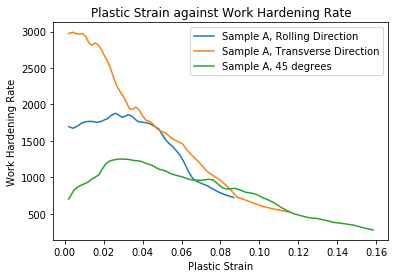

In [12]:
plot_whr(RD_A_Plastic_Stress,RD_A_Plastic_Strain,'Sample A, Rolling Direction')
plot_whr(TD_A_Plastic_Stress,TD_A_Plastic_Strain,'Sample A, Transverse Direction')
plot_whr(FFD_A_Plastic_Stress,FFD_A_Plastic_Strain,'Sample A, 45 degrees')
plt.savefig('Sample_A_WHR_DIC.png')

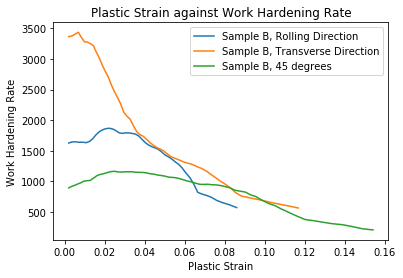

In [13]:
plot_whr(RD_B_Plastic_Stress,RD_B_Plastic_Strain,'Sample B, Rolling Direction')
plot_whr(TD_B_Plastic_Stress,TD_B_Plastic_Strain,'Sample B, Transverse Direction')
plot_whr(FFD_B_Plastic_Stress,FFD_B_Plastic_Strain,'Sample B, 45 degrees')
plt.savefig('Sample_B_WHR_DIC.png')

### Using Considere's Criterion

In [14]:
#Edit this to work with different stress and strains!
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def plot_criterion(plastic_strain,plastic_stress,strain,stress,whrname,DICname):
    fig, ax1 = plt.subplots()
    ax1.plot(plastic_strain[::15],calc_reduced_whr(plastic_stress,plastic_strain),'C0-',label=whrname)
    
    diff = np.shape(stress)[0] - np.shape(plastic_strain)[0]
    cropped_stress = stress[diff:]
    ax2 = ax1.twinx()
    ax2.plot(plastic_strain,cropped_stress,'C1-',label = DICname)
    
    index = np.where(plastic_strain[::15]>0.03)[0][0]
    intersect = np.where(cropped_stress[::15][index:]>calc_reduced_whr(plastic_stress,plastic_strain)[index:])[0][0] + index
    ax2.plot(plastic_strain[::15][intersect],cropped_stress[::15][intersect],'ro')
 
    plt.title('Plotting Consideres Criterion')
    ax1.set_xlabel('Plastic Strain')
    ax1.set_ylabel('Work Hardening Rate')
    ax2.set_ylabel('True Stress (MPa)')
    
    if 'RD' in namestr(plastic_strain, globals()):
        a,b = 0,2000
    if 'TD' in namestr(plastic_strain, globals()):
        a,b = 0,3500
    if 'FFD' in namestr(plastic_strain, globals()):
        a,b = 0,1500
    ax1.set_ylim(a,b)
    ax2.set_ylim(a,b)
    
    labels = ax1.plot(plastic_strain[::15],calc_reduced_whr(plastic_stress,plastic_strain),'C0-',label=whrname) + ax2.plot(plastic_strain,cropped_stress,'C1-',label = DICname)
    labs = [l.get_label() for l in labels]
    ax1.legend(labels, labs, loc=0)

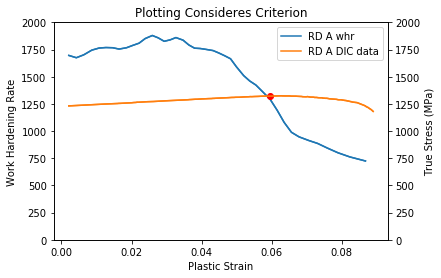

In [15]:
plot_criterion(RD_A_Plastic_Strain,RD_A_Plastic_Stress,RD_A_True_Strain,RD_A_True_Stress,'RD A whr','RD A DIC data')
plt.savefig('RD_A_Consideres_DIC.png')
plt.show()

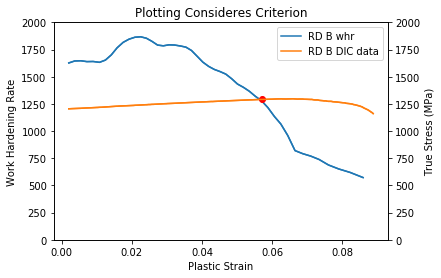

In [16]:
plot_criterion(RD_B_Plastic_Strain,RD_B_Plastic_Stress,RD_B_True_Strain,RD_B_True_Stress,'RD B whr','RD B DIC data')
plt.savefig('RD_B_Consideres_DIC.png')
plt.show()

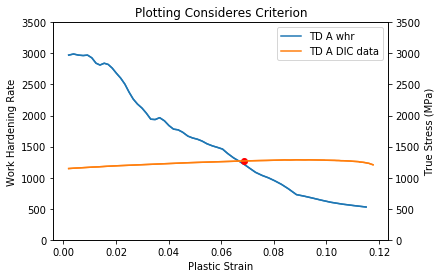

In [17]:
plot_criterion(TD_A_Plastic_Strain,TD_A_Plastic_Stress,TD_A_True_Strain,TD_A_True_Stress,'TD A whr','TD A DIC data')
plt.savefig('TD_A_Consideres_DIC.png')
plt.show()

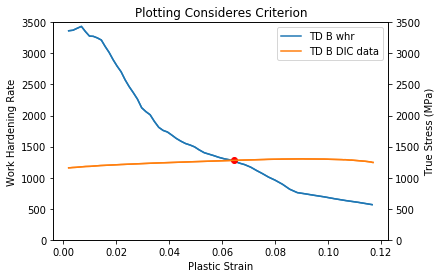

In [18]:
plot_criterion(TD_B_Plastic_Strain,TD_B_Plastic_Stress,TD_B_True_Strain,TD_B_True_Stress,'TD B whr','TD B DIC data')
plt.savefig('TD_B_Consideres_DIC.png')
plt.show()

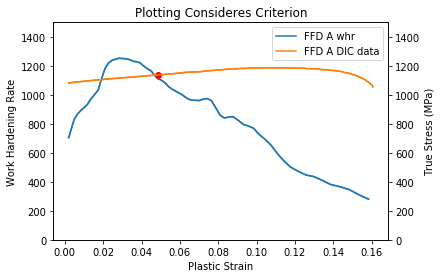

In [19]:
plot_criterion(FFD_A_Plastic_Strain,FFD_A_Plastic_Stress,FFD_A_True_Strain,FFD_A_True_Stress,'FFD A whr','FFD A DIC data')
plt.savefig('45deg_A_Consideres_DIC.png')
plt.show()

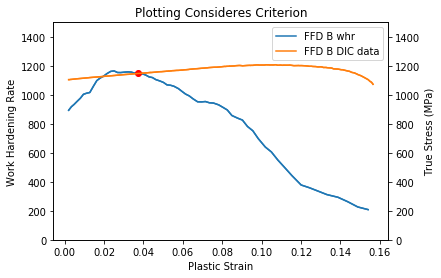

In [20]:
plot_criterion(FFD_B_Plastic_Strain,FFD_B_Plastic_Stress,FFD_B_True_Strain,FFD_B_True_Stress,'FFD B whr','FFD B DIC data')
plt.savefig('45deg_B_Consideres_DIC.png')
plt.show()

### Finding the max of the DIC data

In [21]:
def find_DIC_max(strain_data,stress_data):
    index = np.where(stress_data==np.max(stress_data))[0][0]
    strain_val = strain_data[index]
    print('Value of strain at which stress is maximum =',np.round(strain_val,4))

### Plotting point of intersection against engineering stress-strain curves

In [22]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
    
def point_check(plastic_strain,plastic_stress,true_strain,true_stress,strain_data,stress_data,m,name):
    diff = np.shape(true_stress)[0] - np.shape(plastic_strain)[0]
    cropped_true = true_stress[diff:]
    index = np.where(plastic_strain[::15]>0.03)[0][0]
    intersect = np.where(cropped_true[::15][index:]>calc_reduced_whr(plastic_stress,plastic_strain)[index:])[0][0] + index
    plas_strain_val = plastic_strain[::15][intersect]
    stress_val = cropped_true[::15][intersect]
    
    true_strain_back = plas_strain_val + stress_val/m
    eng_strain_back = (np.exp(true_strain_back)-1)

    closest_val = find_nearest(strain_data,eng_strain_back)
    closest_val_index = np.where(strain_data==closest_val)[0][0]

    plt.plot(strain_data,stress_data,'-',label=name)
    plt.plot(strain_data[closest_val_index],stress_data[closest_val_index],'ro')
    plt.xlabel('Engineering Strain')
    plt.ylabel('Engineering Stress (MPa)')
    plt.legend(loc='best')
    plt.title('Engineering Stress-Strain with Consideres Point of Necking')
    print('Value of strain at which Consideres Criterion predicts necking to occur =',np.round(strain_data[closest_val_index],4))

Value of strain at which stress is maximum = 0.0762
Value of strain at which Consideres Criterion predicts necking to occur = 0.0741


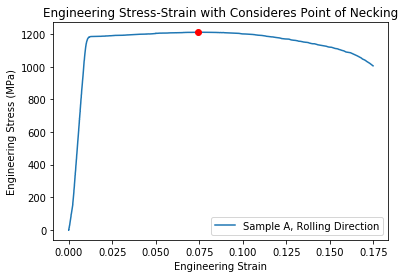

In [23]:
find_DIC_max(RD_A_Strain,RD_A_Stress)
point_check(RD_A_Plastic_Strain,RD_A_Plastic_Stress,RD_A_True_Strain,RD_A_True_Stress,RD_A_Strain,RD_A_Stress,RD_A_m,'Sample A, Rolling Direction')
plt.savefig('RD_A_Consideres_Point_DIC.png')

Value of strain at which stress is maximum = 0.0728
Value of strain at which Consideres Criterion predicts necking to occur = 0.0703


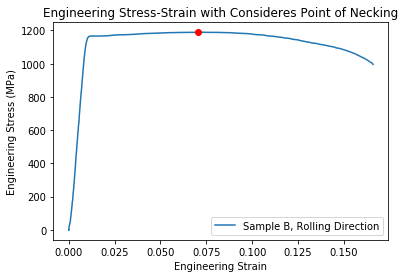

In [24]:
find_DIC_max(RD_B_Strain,RD_B_Stress)
point_check(RD_B_Plastic_Strain,RD_B_Plastic_Stress,RD_B_True_Strain,RD_B_True_Stress,RD_B_Strain,RD_B_Stress,RD_B_m,'Sample B, Rolling Direction')
plt.savefig('RD_B_Consideres_Point_DIC.png')

Value of strain at which stress is maximum = 0.0838
Value of strain at which Consideres Criterion predicts necking to occur = 0.0837


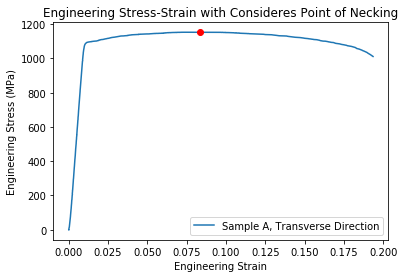

In [25]:
find_DIC_max(TD_A_Strain,TD_A_Stress)
point_check(TD_A_Plastic_Strain,TD_A_Plastic_Stress,TD_A_True_Strain,TD_A_True_Stress,TD_A_Strain,TD_A_Stress,TD_A_m,'Sample A, Transverse Direction')
plt.savefig('TD_A_Consideres_Point_DIC.png')

Value of strain at which stress is maximum = 0.0835
Value of strain at which Consideres Criterion predicts necking to occur = 0.079


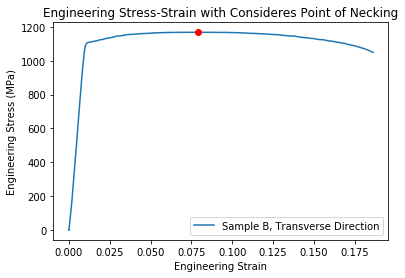

In [26]:
find_DIC_max(TD_B_Strain,TD_B_Stress)
point_check(TD_B_Plastic_Strain,TD_B_Plastic_Stress,TD_B_True_Strain,TD_B_True_Stress,TD_B_Strain,TD_B_Stress,TD_B_m,'Sample B, Transverse Direction')
plt.savefig('TD_B_Consideres_Point_DIC.png')

Value of strain at which stress is maximum = 0.0111
Value of strain at which Consideres Criterion predicts necking to occur = 0.0591


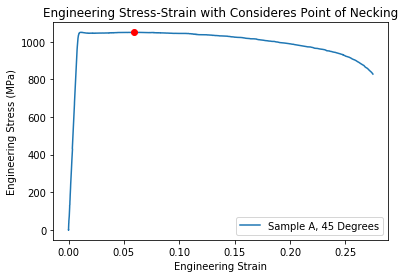

In [27]:
find_DIC_max(FFD_A_Strain,FFD_A_Stress)
point_check(FFD_A_Plastic_Strain,FFD_A_Plastic_Stress,FFD_A_True_Strain,FFD_A_True_Stress,FFD_A_Strain,FFD_A_Stress,FFD_A_m,'Sample A, 45 Degrees')
plt.savefig('45deg_A_Consideres_Point_DIC.png')

Value of strain at which stress is maximum = 0.0118
Value of strain at which Consideres Criterion predicts necking to occur = 0.0483


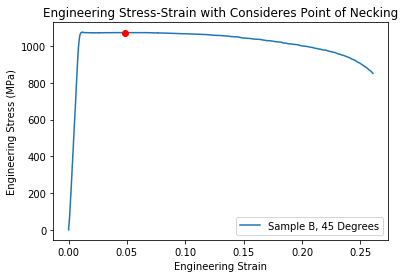

In [28]:
find_DIC_max(FFD_B_Strain,FFD_B_Stress)
point_check(FFD_B_Plastic_Strain,FFD_B_Plastic_Stress,FFD_B_True_Strain,FFD_B_True_Stress,FFD_B_Strain,FFD_B_Stress,FFD_B_m,'Sample B, 45 Degrees')
plt.savefig('45deg_B_Consideres_Point_DIC.png')

Note that for both of the 45 degree graphs above plotting Considere's criterion, the value shown by the red dot does not match up with the maximum value, as the maximum value of stress for these samples is measured to occur at yield.

### Outputting these values into a table

In [29]:
def return_eng_max(strain_data,stress_data):
    stress_max = np.max(stress_data)
    index = np.where(stress_data==np.max(stress_data))[0][0]
    return np.round(strain_data[index]*100,4)

def return_consideres_val(plastic_strain,plastic_stress,true_strain,true_stress,strain_data,stress_data,m):
    diff = np.shape(true_stress)[0] - np.shape(plastic_strain)[0]
    cropped_true = true_stress[diff:]
    index = np.where(plastic_strain[::15]>0.03)[0][0]
    intersect = np.where(cropped_true[::15][index:]>calc_reduced_whr(plastic_stress,plastic_strain)[index:])[0][0] + index
    plas_strain_val = plastic_strain[::15][intersect]
    stress_val = cropped_true[::15][intersect]
    true_strain_back = plas_strain_val + stress_val/m
    eng_strain_back = (np.exp(true_strain_back)-1)
    closest_val = find_nearest(strain_data,eng_strain_back)
    closest_val_index = np.where(strain_data==closest_val)[0][0]
    return np.round(strain_data[closest_val_index]*100,4)

In [30]:
from IPython.display import HTML,display
import tabulate

list_1 = ['Sample A, Rolling Direction',
          'Sample B, Rolling Direction',
          'Sample A, Transverse Direction',
          'Sample B, Transverse Direction',
          'Sample A, 45 Degrees',
          'Sample B, 45 Degrees']
list_2 = [return_consideres_val(RD_A_Plastic_Strain,RD_A_Plastic_Stress,RD_A_True_Strain,RD_A_True_Stress,RD_A_Strain,RD_A_Stress,RD_A_m),
          return_consideres_val(RD_B_Plastic_Strain,RD_B_Plastic_Stress,RD_B_True_Strain,RD_B_True_Stress,RD_B_Strain,RD_B_Stress,RD_B_m),
          return_consideres_val(TD_A_Plastic_Strain,TD_A_Plastic_Stress,TD_A_True_Strain,TD_A_True_Stress,TD_A_Strain,TD_A_Stress,TD_A_m),
          return_consideres_val(TD_B_Plastic_Strain,TD_B_Plastic_Stress,TD_B_True_Strain,TD_B_True_Stress,TD_B_Strain,TD_B_Stress,TD_B_m),
          return_consideres_val(FFD_A_Plastic_Strain,FFD_A_Plastic_Stress,FFD_A_True_Strain,FFD_A_True_Stress,FFD_A_Strain,FFD_A_Stress,FFD_A_m),
          return_consideres_val(FFD_B_Plastic_Strain,FFD_B_Plastic_Stress,FFD_B_True_Strain,FFD_B_True_Stress,FFD_B_Strain,FFD_B_Stress,FFD_B_m)]
list_3 = [return_eng_max(RD_A_Strain,RD_A_Stress),
          return_eng_max(RD_B_Strain,RD_B_Stress),
          return_eng_max(TD_A_Strain,TD_A_Stress),
          return_eng_max(TD_B_Strain,TD_B_Stress),
          return_eng_max(FFD_A_Strain,FFD_A_Stress),
          return_eng_max(FFD_B_Strain,FFD_B_Stress)]
                                                     
array = np.array((list_1,list_2,list_3))
table = array.T
headers= ['Sample','Consideres Strain Value for Necking (%)','Engineering Strain Value for Necking (%)']
display(HTML(tabulate.tabulate(table, headers = headers,tablefmt='html')))

#Change format to 'latex' for it to output text for putting into latex!

Sample,Consideres Strain Value for Necking (%),Engineering Strain Value for Necking (%)
"Sample A, Rolling Direction",7.4138,7.6238
"Sample B, Rolling Direction",7.0331,7.2822
"Sample A, Transverse Direction",8.3657,8.3797
"Sample B, Transverse Direction",7.9029,8.3534
"Sample A, 45 Degrees",5.9105,1.1127
"Sample B, 45 Degrees",4.8328,1.1811
